<a href="https://colab.research.google.com/github/elainedias16/TCC/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BBC News Dataset

# Reading the Dataset and Creating the Dataframe

In [256]:
import pandas as pd

id_file = '1m41gWGwnLYo0nAEOABnU_MH_SCQHWfjS'
url_file = 'https://drive.google.com/uc?id={}'.format(id_file)

def create_dataframe(path):
    columns=['genre', 'filename', 'title', 'content']
    df =  pd.read_table(
    path,
    header=None,
    names=columns,
    sep= '\t',
    engine= 'python'
    )
    return df


df = create_dataframe(url_file)
df = df.drop(0).reset_index(drop=True)

df.tail()

,genre,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


In [ ]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import spacy
from spacy.lang.en.examples import sentences

!pip install unidecode
import unidecode
from nltk.stem.porter import PorterStemmer
!python -m spacy download en_core_web_sm


## Create dataset with less samples

In [257]:
import random

def create_balanced_small_df(df, genres, num):
  small_df_list = []
  for genre in genres:
    sample_rows = df.sample(num)
    small_df_list.append(sample_rows)
  return pd.concat(small_df_list).reset_index(drop=True)

def create_imbalanced_small_df(df, genres, num_max):
  small_df_list = []
  for genre in genres:
    qtd = random.randint(1, num_max)
    sample_rows = df.sample(qtd)
    small_df_list.append(sample_rows)
  return pd.concat(small_df_list).reset_index(drop=True)


In [258]:
genres = genres = df['genre'].unique()
num_max = 50 # Max number of docs by genre in small df
num = 20 # Number of docs by genre in small df
# small_df = create_balanced_small_df(df, genres, num)
small_df = create_imbalanced_small_df(df, genres, num_max)

# Pre Processing

In [259]:
def remove_non_alphanumeric(text):
    words = ''
    for w in text:
        words += w if w.isalnum() else ' '
    return words

def remove_accents(text):
  return unidecode.unidecode(text)


def lowercasting(tokens):
  tokens = [w.lower() for w in tokens]
  return tokens

def remove_stop_words(tokens):
  stop_words = set(stopwords.words('english')) #List of stop words in english
  tokens = [token for token in tokens if token not in stop_words]
  return tokens


def stemming(tokens):
  porter = PorterStemmer()
  tokens = [porter.stem(token) for token in tokens]
  return tokens


def lemmanization(text):
    nlp = spacy.load("en_core_web_sm")    # Load English language model
    doc = nlp(text)   # Process the text using the Spacy NLP
    tokens = [token.lemma_ for token in doc]
    return tokens


def pre_processing_aux(text):
  words = remove_non_alphanumeric(text)
  words = remove_accents(words)
  tokens = word_tokenize(words)
  tokens = lowercasting(tokens)
  tokens = remove_stop_words(tokens)
  words = ' '.join(tokens)
  tokens = lemmanization(words)
  tokens = stemming(tokens)
  return ' '.join(tokens)


In [260]:
def pre_processing(df):
    df['content'] = df['content'].apply(pre_processing_aux)
    return df

###########################################################
# To prossegue with all dataset, put df on parameter
# To prossegue with small dataset, put small_df in paramter
############################################################

df = pre_processing(small_df)
df.tail()

,genre,filename,title,content
159,sport,202.txt,Santini resigns as Spurs manager,tottenham manag jacqu santini resign person re...
160,tech,293.txt,File-swappers ready new network,legal attack websit help peopl swap pirat film...
161,business,263.txt,Split-caps pay £194m compensation,investor lose money follow split capit invest ...
162,politics,221.txt,Clarke defends terror detentions,home secretari defend decis releas foreign ter...
163,politics,017.txt,Tsunami debt deal to be announced,chancellor gordon brown say hope announc deal ...


# Basic statistics analysis

##Documents number by class

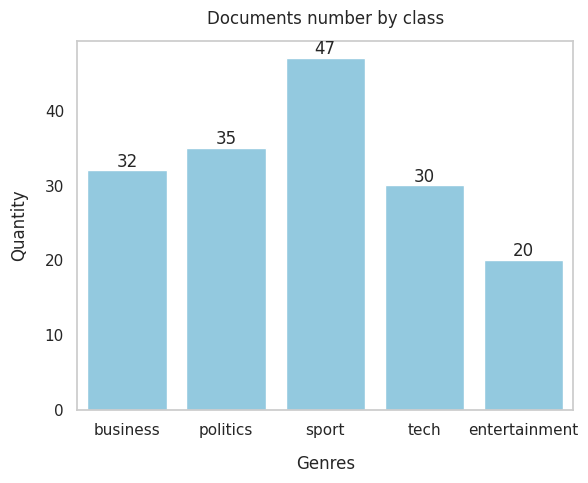

In [261]:
import matplotlib.pyplot as plt
import seaborn

genres = df['genre'].unique()

def plot_doc_by_class(genres):
  ax = sns.countplot(x = 'genre', data = df , color='skyblue')
  ax.yaxis.grid(False)
  plt.title('Documents number by class', pad=12)
  plt.xlabel('Genres', labelpad=12)
  plt.ylabel('Quantity', labelpad=12)

  bars = ax.patches
  # Put numbers of docs above bars
  for bar in bars:
        height = int(bar.get_height())
        plt.text(bar.get_x() + bar.get_width()/2, height, height, ha='center', va='bottom')

  plt.show()


plot_doc_by_class(genres)

#Top 30 most frequent words

In [268]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn

def get_genre_content(df, genre):
  content = df.loc[df['genre'] == genre, 'content'].str.cat(sep=' ')
  return content

# dict_content = {}

# for genre in genres:
#     dict_content[genre] = get_genre_content(df, genre)

# print("------------")
# print(dict_content)

def create_dict_content(df):
  dict_content = {}

  for genre in genres:
      dict_content[genre] = get_genre_content(df, genre)
      if 'all' in dict_content:
        dict_content['all'] += get_genre_content(df, genre)
      else:
          dict_content['all'] = get_genre_content(df, genre)
  return dict_content


dict_content = create_dict_content(df)
print(dict_content.keys())

###################

# count_content = {}
# for genre, content in dict_content.items():
#     count_content[genre] = Counter(content.split())

# print(count_content)

# def get_top_n_words(top_n, count_words):
#     most_common_words = {}
#     for word, count in count_words.most_common(top_n):
#         most_common_words[word] = count
#     return most_common_words


def create_count_content(df):
  count_content = {}
  for genre, content in dict_content.items():
      count_content[genre] = Counter(content.split())
  return count_content


count_content = create_count_content(df)
print(count_content.keys())

dict_keys(['business', 'all', 'politics', 'sport', 'tech', 'entertainment'])
dict_keys(['business', 'all', 'politics', 'sport', 'tech', 'entertainment'])


In [242]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_h_most_common_words(top_n, count_content, genre, title, fontsize):
    most_common = get_top_n_words(top_n, count_content[genre])
    most_common = sorted(most_common.items(), key=lambda x: x[1])
    words = [item[0] for item in most_common ]
    counts = [item[1] for item in most_common ]
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Quantity', labelpad=15)
    plt.ylabel('Tokens', labelpad=15)
    plt.grid(False)
    plt.title(title, pad=15)
    #Display number of token in front of each bar
    for i in range(len(words)):
      plt.text(counts[i], i, ' ' + str(counts[i]), ha='left', va='center')



##Top 30 most frequent tokens in business

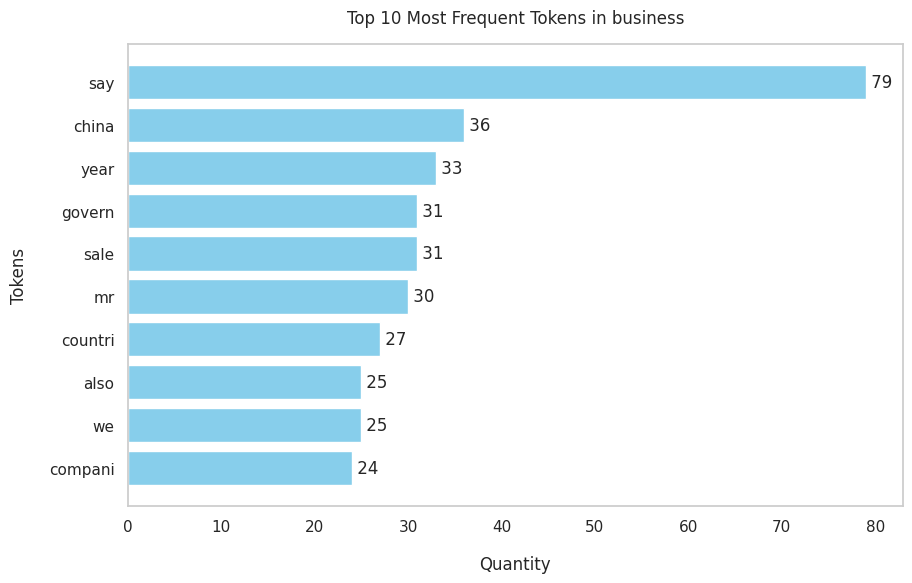

In [252]:
top_n = 10
fontsize = 12
title_business = 'Top {} Most Frequent Tokens in business'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'business', title_business, fontsize)
# common_words_business = get_top_n_words(top_n, count_content['business'])
# print(common_words_business)

##Top 30 most frequent tokens in entertainment




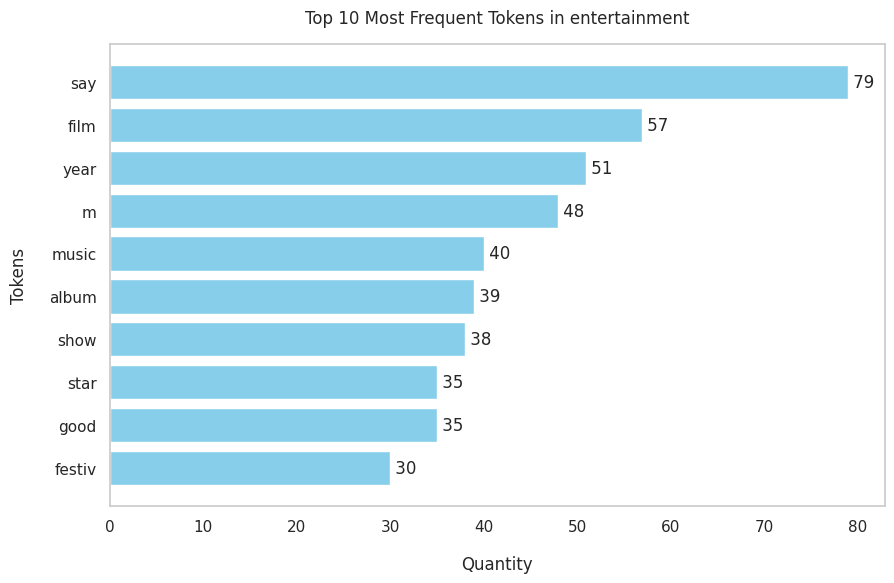

In [251]:
top_n = 10
fontsize = 12
title_entertainment = 'Top {} Most Frequent Tokens in entertainment'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'entertainment', title_entertainment, fontsize)
# common_words_entertainment = get_top_n_words(top_n, count_content['entertainment'])
# print(common_words_entertainment)

##Top 30 most frequent tokens in politics

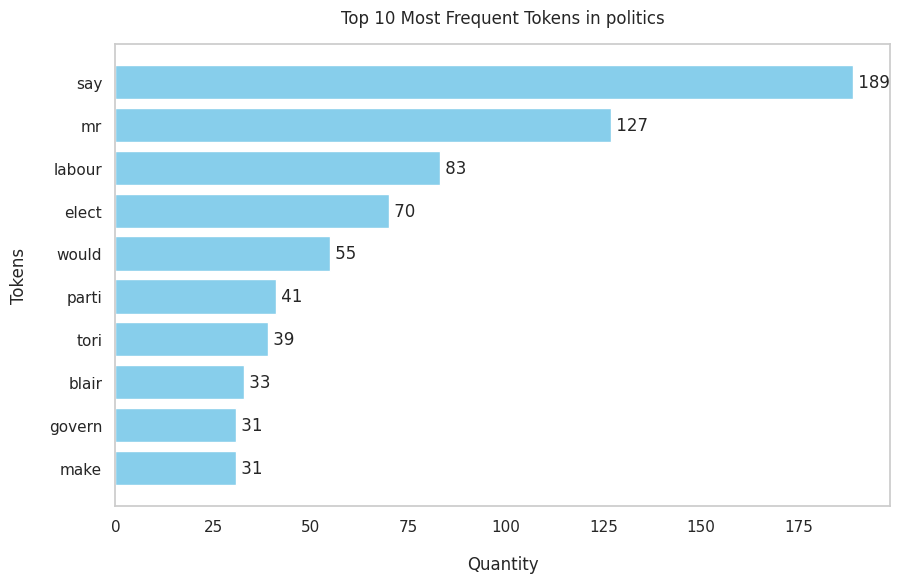

In [250]:
top_n = 10
fontsize = 12
title_politics = 'Top {} Most Frequent Tokens in politics'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'politics', title_politics, fontsize)
# common_words_politics = get_top_n_words(top_n, count_content['politics'])
# print(common_words_politics)

##Top 30 most frequent tokens in sport

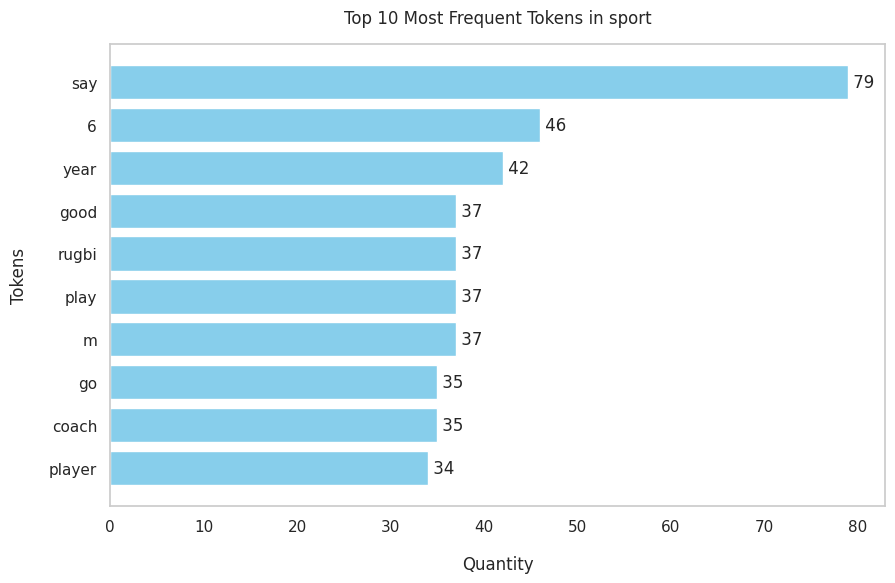

In [249]:
top_n = 10
fontsize = 12
title_sport = 'Top {} Most Frequent Tokens in sport'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'sport', title_sport, fontsize)
# common_words_sport = get_top_n_words(top_n, count_content['sport'])
# print(common_words_sport)

##Top 30 most frequent tokens in tech

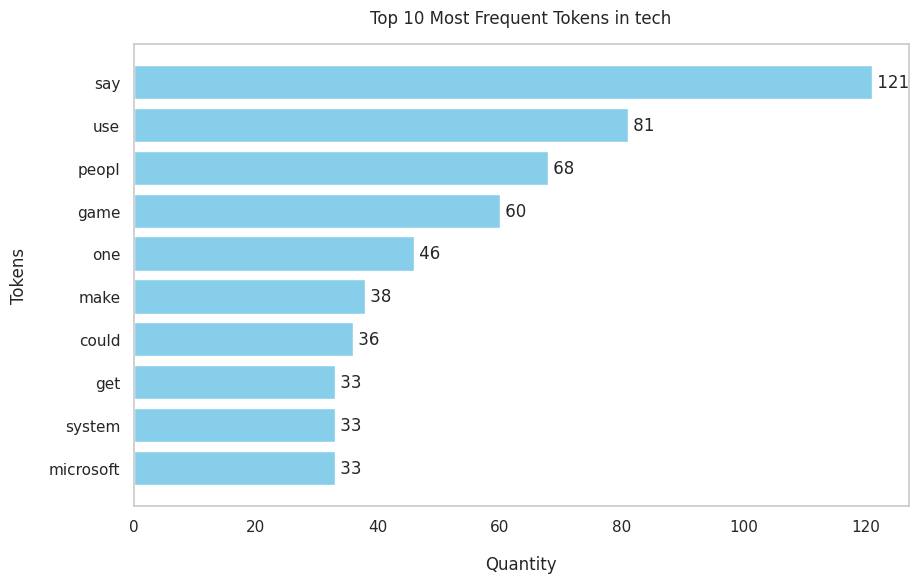

In [248]:
top_n = 10
fontsize = 12
title_tech = 'Top {} Most Frequent Tokens in tech'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'tech', title_tech, fontsize)
# common_words_tech = get_top_n_words(top_n, count_content['tech'])
# print(common_words_politics)

##Top 30 most frequent tokens in all dataset

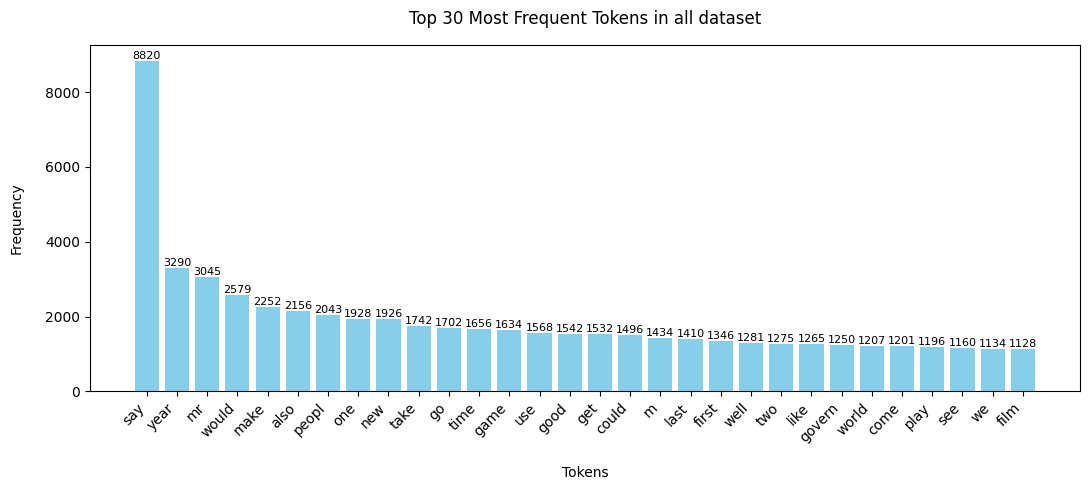

{'say': 8820, 'year': 3290, 'mr': 3045, 'would': 2579, 'make': 2252, 'also': 2156, 'peopl': 2043, 'one': 1928, 'new': 1926, 'take': 1742, 'go': 1702, 'time': 1656, 'game': 1634, 'use': 1568, 'good': 1542, 'get': 1532, 'could': 1496, 'm': 1434, 'last': 1410, 'first': 1346, 'well': 1281, 'two': 1275, 'like': 1265, 'govern': 1250, 'world': 1207, 'come': 1201, 'play': 1196, 'see': 1160, 'we': 1134, 'film': 1128}


In [ ]:
fontsize=8
title_all = 'Top {} Most Frequent Tokens in all dataset'.format(top_n)
plot_most_common_words(top_n, common_words_all, title_all, fontsize)
print(common_words_all)

#Frequency of class by word

In [ ]:
import random

count_genres = {
  'business': count_business,
  'entertainment' : count_entertainment,
  'politics' : count_politics,
  'sport' : count_sport,
  'tech' : count_tech
}


#Choose 10 random tokens in all content of news
content_all_split = content_all.split()
random_words = random.sample(content_all_split, 3)
print("random words: ", random_words)

def get_counts_per_genre(word, count_genres):
    counts_per_genre = {}  #Dictionary to store word count in each class
    for genre, content_counter in count_genres.items():
        if word in content_counter:
            counts_per_genre[genre] = content_counter[word]  # Adds the word count in the class to the dictionary
    return counts_per_genre


def get_frequency_class_by_word(selected_words, count_genres):
    dict_frequency = {}
    for word in selected_words:
        dict_frequency[word] = get_counts_per_genre(word, count_genres)
    return dict_frequency


dict_frequency = get_frequency_class_by_word(random_words, count_genres)
print(dict_frequency)

random words:  ['pop', 'video', 'look']
{'pop': {'entertainment': 104, 'politics': 2, 'sport': 2, 'tech': 17}, 'video': {'business': 15, 'entertainment': 41, 'politics': 10, 'sport': 15, 'tech': 288}, 'look': {'business': 127, 'entertainment': 72, 'politics': 125, 'sport': 225, 'tech': 231}}


## Frequency of words by documents

In [ ]:
from collections import Counter

def get_frequency(df):
    frequency = {}
    for index, row in df.iterrows():
        filename = row['filename']
        word_counts = dict(Counter(row['content'].split()))
        if filename not in frequency:
          frequency[filename] = word_counts
    return frequency



frequency = get_frequency(df)
print(frequency)


{'001.txt': {'quarterli': 1, 'profit': 9, 'we': 1, 'media': 1, 'giant': 1, 'timewarn': 7, 'jump': 1, '76': 1, '1': 1, '13bn': 1, '600': 1, 'm': 5, 'three': 2, 'month': 1, 'decemb': 1, '639': 1, 'year': 4, 'earli': 2, 'firm': 1, 'one': 2, 'big': 1, 'investor': 1, 'googl': 2, 'benefit': 1, 'sale': 4, 'high': 4, 'speed': 2, 'internet': 4, 'connect': 1, 'advert': 1, 'say': 5, 'fourth': 3, 'quarter': 4, 'rise': 2, '2': 1, '11': 1, '1bn': 1, '10': 1, '9bn': 1, 'buoy': 1, 'gain': 1, 'offset': 1, 'dip': 1, 'warner': 3, 'bro': 1, 'less': 1, 'user': 1, 'aol': 7, 'time': 2, 'friday': 1, 'own': 1, '8': 2, 'search': 1, 'engin': 1, 'busi': 1, 'mix': 1, 'fortun': 1, 'lose': 1, '464': 1, '000': 1, 'subscrib': 2, 'lower': 1, 'preced': 1, 'howev': 1, 'compani': 2, 'underli': 1, 'except': 1, 'item': 1, 'back': 1, 'strong': 2, 'advertis': 2, 'revenu': 4, 'hope': 1, 'increas': 1, 'offer': 2, 'onlin': 1, 'servic': 1, 'free': 1, 'custom': 2, 'tri': 1, 'sign': 1, 'exist': 1, 'broadband': 1, 'also': 2, 'restat

In [ ]:
df.head()

,genre,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,quarterli profit we media giant timewarn jump ...
1,business,002.txt,Dollar gains on Greenspan speech,dollar hit high level euro almost three month ...
2,business,003.txt,Yukos unit buyer faces loan claim,owner embattl russian oil giant yuko ask buyer...
3,business,004.txt,High fuel prices hit BA's profits,british airway blame high fuel price 40 drop p...
4,business,005.txt,Pernod takeover talk lifts Domecq,share uk drink food firm alli domecq rise spec...


In [ ]:
content_line = df['content'].iloc[0]
content_line

# Frequency of documents by words

In [ ]:
######fix it :::::::::::::::::::::

In [ ]:
def get_counts_by_doc(df, words):
  dict_f = {}
  for word in content_all_split:
    counts_by_doc = {word : {}}
    for index, row in df.iterrows():
      filename = row['filename']  # Nome do documento
      word_doc_counts = dict(Counter(row['content'].split()))
      if word in word_doc_counts.items():
        counts_by_doc[filename] = word_doc_counts[word]
      else:
        counts_by_doc[filename] = 0
    dict_f.update(counts_by_doc)
  return dict_f


doc_by_word = get_counts_by_doc(df, content_all_split)